In [3]:
%%time

from utils.utils import create_dataset, Trainer
from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))


Training on [cuda:0].
CPU times: user 740 ms, sys: 362 ms, total: 1.1 s
Wall time: 2.39 s


In [4]:
%%time

dataset = create_dataset('amazon-books', sample_num=100000, sequence_length=40, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()


CPU times: user 59.4 s, sys: 1.93 s, total: 1min 1s
Wall time: 1min 4s


In [5]:
class BaseModel(nn.Module):
    
    def __init__(self, field_dims, embed_dim=4):
        # 这里只用用户的行为序列作为特征，没用户数据
        super(BaseModel, self).__init__()
        
        # 商品 embedding 层
        self.embed = Embedding(field_dims[0], embed_dim)
        self.mlp = MultiLayerPerceptron([embed_dim * 2, 200, 80, 1])
        
    def forward(self, x):
        user_behaviors = x[:, :-1]
        mask = (user_behaviors > 0).float().unsqueeze(-1)
        avg = mask.mean(dim=1, keepdim=True)
        weight = mask.mul(avg)
        user_behaviors_embedding = self.embed(user_behaviors).mul(weight).sum(dim=1)
        ad_embedding = self.embed(x[:,-1])
        
        concated = torch.hstack([user_behaviors_embedding, ad_embedding])
        output = self.mlp(concated)
        output = torch.sigmoid(output)
        return output

    
class Dice(nn.Module):
    
    def __init__(self):
        super(Dice, self).__init__()
        self.alpha = nn.Parameter(torch.zeros((1, )))
        
    def forward(self, x):
        avg = x.mean(dim=0)
        std = x.std(dim=0)
        norm_x = (x - avg) / std
        p = torch.sigmoid(norm_x)

        return x.mul(p) + self.alpha * x.mul(1 - p)


class ActivationUnit(nn.Module):
    
    def __init__(self, embed_dim=4):
        super(ActivationUnit, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim * (embed_dim + 2) , 36),
            Dice(),
            nn.Linear(36, 1),
        )
    
    def forward(self, x):
        behaviors = x[:, :-1]
        num_behaviors = behaviors.shape[1]
        
        ads = x[:, [-1] * num_behaviors]
        
        # outer product
        embed_dim = x.shape[-1]
        i1, i2 = [], []
        for i in range(embed_dim):
            for j in range(embed_dim):
                i1.append(i)
                i2.append(j)
        p = behaviors[:,:, i1].mul(ads[:,:, i2]).reshape(behaviors.shape[0], behaviors.shape[1], -1)
        
        att = self.mlp(torch.cat([behaviors, p, ads], dim=2))
        return att
        

class DeepInterestNetwork(nn.Module):
    
    def __init__(self, field_dims, embed_dim=4):
        super(DeepInterestNetwork, self).__init__()
        # 商品 embedding 层
        self.embed = Embedding(field_dims[0], embed_dim)
        self.attention = ActivationUnit(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim * 2, 200),
            Dice(),
            nn.Linear(200, 80),
            Dice(),
            nn.Linear(80, 1)
        )
        
    def forward(self, x):
        mask = (x > 0).float().unsqueeze(-1)  # (batch_size, num_behaviors+1, 1)
        behaviors_ad_embeddings = self.embed(x).mul(mask)  # (batch_size, num_behaviors+1, embed_dim)
        att = self.attention(behaviors_ad_embeddings)  # (batch_size, num_behaviors, 1)
        
        weighted_behaviors = behaviors_ad_embeddings[:, :-1].mul(mask[:, :-1]).mul(att)  # (batch_size, num_behaviors, embed_dim)
        user_interest = weighted_behaviors.sum(dim=1)  # (batch_size, embed_dim)
        
        concated = torch.hstack([user_interest, behaviors_ad_embeddings[:, -1]])
        output = self.mlp(concated)
        output = torch.sigmoid(output)
        return output


 40%|████      | 242/600 [00:41<01:01,  5.84it/s]


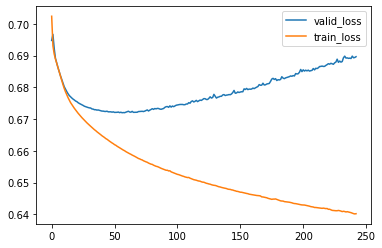

train_loss: 0.64894 | train_metric: 0.63256
valid_loss: 0.67767 | valid_metric: 0.60572
test_loss:  0.67745 | test_auc:  0.60432
CPU times: user 40.2 s, sys: 881 ms, total: 41.1 s
Wall time: 41.7 s


In [6]:
%%time

EMBEDDING_DIM = 8
LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 4096
EPOCH = 600
TRIAL = 100

bm = BaseModel(field_dims, EMBEDDING_DIM).to(device)
optimizer = optim.Adam(bm.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
criterion = nn.BCELoss()

trainer = Trainer(bm, optimizer, criterion, BATCH_SIZE)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_metric = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_auc:  {:.5f}'.format(test_loss, test_metric))


 28%|██▊       | 168/600 [02:36<06:42,  1.07it/s]


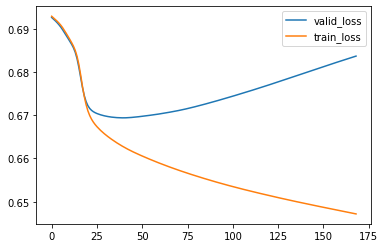

train_loss: 0.65741 | train_metric: 0.62400
valid_loss: 0.67093 | valid_metric: 0.60647
test_loss:  0.67118 | test_auc:  0.60546
CPU times: user 2min 35s, sys: 661 ms, total: 2min 36s
Wall time: 2min 36s


In [7]:
%%time

EMBEDDING_DIM = 8
LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 4096
EPOCH = 600
TRIAL = 100

din = DeepInterestNetwork(field_dims, EMBEDDING_DIM).to(device)
optimizer = optim.Adam(din.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
criterion = nn.BCELoss()

trainer = Trainer(din, optimizer, criterion, BATCH_SIZE)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_metric = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_auc:  {:.5f}'.format(test_loss, test_metric))
